# Importación de librerías

In [1]:
import requests
import json
import polars as pl
import aiohttp
import asyncio
import time
import nest_asyncio
import matplotlib.pyplot as plt
import math
from datetime import datetime
import seaborn as sns
import numpy as np
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


In [2]:
#Funciones 
def customized_bar_plot(num_subplots, x_vars, y_vars, x_labels, y_labels, titles):
    num_columns = min(num_subplots, 3)  
    num_rows = math.ceil(num_subplots / num_columns)  
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(25, 8 * num_rows))
    
    if num_subplots == 1:
        axes = [axes]
    elif num_rows == 1 or num_columns == 1:
        axes = axes.flatten()
    else:
        axes = [ax for sublist in axes for ax in sublist]

    for i in range(num_subplots):
        x = x_vars[i]
        y = y_vars[i]

        if isinstance(y, list):
            max_value_index = y.index(max(y))  
        else:
            max_value_index = y.idxmax()  
        
        colors = ['yellow' if idx == max_value_index else 'grey' for idx in range(len(y))]
        
        axes[i].bar(x, y, color=colors)
        axes[i].set_xlabel(x_labels[i])
        axes[i].set_ylabel(y_labels[i])
        axes[i].set_title(titles[i])
        axes[i].tick_params(axis='x', rotation=90, labelsize=10)  
        axes[i].spines['right'].set_visible(False) 
        axes[i].spines['top'].set_visible(False)
    
    for j in range(num_subplots, len(axes)):
        fig.delaxes(axes[j])
    plt.subplots_adjust(wspace=0.3, hspace=0.3, bottom=0.2)
    plt.show()


def agrupacion_por_columna(df, columnas_agrupar):
    agrupacion = df.group_by(columnas_agrupar).agg(
        pl.col("id").count().alias("Número items"),
        ((pl.col("id").count() / len(df)) * 100).alias("Porcentaje del Total (%)")
    ).sort("Número items", descending=True)
    
    return agrupacion


def categorical_eda(df: pl.DataFrame) -> pl.DataFrame:
    analysis_results = []
    for col in df.columns:
        if df[col].dtype in [pl.Utf8, pl.Categorical,pl.Boolean, pl.Binary]:
            n_nulls = df[col].null_count()
            n_unique = df[col].n_unique()
            most_frequent = df[col].mode().to_list()[0]
            analysis_results.append({
                "Columna": col,
                "Número de valores nulos": n_nulls,
                "Categorías únicas": n_unique,
                "Categoría más frecuente": most_frequent
            })
        result_df = pl.DataFrame(analysis_results)
    return result_df


def customized_scatter_plot_with_line(num_subplots, x_vars, y_vars, x_labels, y_labels, titles):
    num_columns = min(num_subplots, 3)  
    num_rows = math.ceil(num_subplots / num_columns) 
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(25, 8 * num_rows))  
    
    if num_subplots == 1:
        axes = [axes] 
    elif num_rows == 1 or num_columns == 1:
        axes = axes.flatten() 
    else:
        axes = [ax for sublist in axes for ax in sublist] 
    for i in range(num_subplots):
        x = x_vars[i]
        y = y_vars[i]
        axes[i].scatter(x, y, color='blue', alpha=0.6)         

        axes[i].set_xlabel(x_labels[i])
        axes[i].set_ylabel(y_labels[i])
        axes[i].set_title(titles[i])
        axes[i].tick_params(axis='x', rotation=90, labelsize=10)  

        axes[i].spines['right'].set_visible(False)
        axes[i].spines['top'].set_visible(False)
    
    for j in range(num_subplots, len(axes)):
        fig.delaxes(axes[j])

    plt.subplots_adjust(wspace=0.3, hspace=0.3, bottom=0.2)
    plt.show()

def customized_scatter_categoria_vs_target(num_subplots, x_vars, y_vars, x_labels, y_labels, titles):
    num_columns = min(num_subplots, 3)  
    num_rows = math.ceil(num_subplots / num_columns) 
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(25, 8 * num_rows))  
    
    if num_subplots == 1:
        axes = [axes] 
    elif num_rows == 1 or num_columns == 1:
        axes = axes.flatten() 
    else:
        axes = [ax for sublist in axes for ax in sublist] 
    for i in range(num_subplots):
        x = x_vars[i]
        y = y_vars[i]
        axes[i].scatter(x, y, color='blue', alpha=0.6)         

        axes[i].set_xlabel(x_labels[i])
        axes[i].set_ylabel(y_labels[i])
        axes[i].set_title(titles[i])
        axes[i].tick_params(axis='x', rotation=90, labelsize=10)  

        axes[i].spines['right'].set_visible(False)
        axes[i].spines['top'].set_visible(False)
    
    for j in range(num_subplots, len(axes)):
        fig.delaxes(axes[j])

    plt.subplots_adjust(wspace=0.3, hspace=0.3, bottom=0.2)
    plt.show()
    
def extract_brand(attributes, atributo, posicion):
    for attr in attributes:
        if atributo in attr:
            return attr[posicion]
        
    return None


def customized_scatter_categoria_vs_target(num_subplots, x_vars, y_vars, x_labels, y_labels, titles, categorias):
    num_columns = min(num_subplots, 3)  
    num_rows = math.ceil(num_subplots / num_columns) 
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(25, 8 * num_rows))  
    
    if num_subplots == 1:
        axes = [axes] 
    elif num_rows == 1 or num_columns == 1:
        axes = axes.flatten() 
    else:
        axes = [ax for sublist in axes for ax in sublist] 
    
    for i in range(num_subplots):
        x = x_vars[i]
        y = y_vars[i]
        category = categorias[i]
        
        unique_categories = np.unique(category)
        colors = plt.cm.get_cmap('tab20', len(unique_categories))
        color_map = {cat: colors(i) for i, cat in enumerate(unique_categories)}
        
        for cat in unique_categories:
            mask = (category == cat)
            axes[i].scatter(x[mask], y[mask], color=color_map[cat], alpha=0.6, label=cat)

        axes[i].set_xlabel(x_labels[i])
        axes[i].set_ylabel(y_labels[i])
        axes[i].set_title(titles[i])
        axes[i].tick_params(axis='x', rotation=90, labelsize=10)  

        axes[i].spines['right'].set_visible(False)
        axes[i].spines['top'].set_visible(False)

        axes[i].legend(title="Categoría: {category}", bbox_to_anchor=(1.05, 1), loc='upper left')

    for j in range(num_subplots, len(axes)):
        fig.delaxes(axes[j])

    plt.subplots_adjust(wspace=0.3, hspace=0.3, bottom=0.2)
    plt.show()

def plot_precio_vs_descuento(items_df, category_col, discount_col, price_col):
    preciopromedio_porcategoria = items_df.group_by(category_col).agg(
        pl.col(discount_col).mean().alias("Descuento promedio"),
        pl.col(price_col).mean().alias("Precio promedio")
    ).sort(by='Descuento promedio', descending=True)

    category_names = preciopromedio_porcategoria[category_col].to_numpy()
    descuento_promedio = preciopromedio_porcategoria['Descuento promedio'].to_numpy()
    precio_promedio = preciopromedio_porcategoria['Precio promedio'].to_numpy()

    num_categories = len(category_names)
    cmap = plt.get_cmap('tab20', num_categories)

    category_to_color = {category: cmap(i) for i, category in enumerate(category_names)}

    colors = [category_to_color[category] for category in category_names]

    fig, ax = plt.subplots(figsize=(10, 6))
    scatter = ax.scatter(descuento_promedio, precio_promedio, 
                         color=colors, alpha=0.7)

    legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=category_to_color[cat], markersize=10) for cat in category_names]
    legend = ax.legend(legend_labels, category_names, loc="center left", bbox_to_anchor=(1, 0.5), title=f"{discount_col} vs {price_col} de : {category_col}")

    plt.subplots_adjust(right=0.75)  
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('Descuento promedio')
    ax.set_ylabel('Precio promedio')
    ax.set_title('Precio vs Descuento promedio por categoría')

    plt.show()

def plot_precio_vs_categoria_polars(items_df, category_col, price_col):
  
    
    categories = items_df[category_col].to_list()
    prices = items_df[price_col].to_list()
    unique_categories = list(set(categories))  
    prices_by_category = [[prices[i] for i in range(len(categories)) if categories[i] == cat] for cat in unique_categories]

    plt.figure(figsize=(12, 6))
    plt.boxplot(prices_by_category, labels=unique_categories, vert=True)
    
    plt.xticks(rotation=90) 
    plt.xlabel('Categoría')
    plt.ylabel('Precio')
    plt.title(f'Precio vs {category_col}')

    plt.tight_layout()  
    plt.show()

# Extracción de datos

In [3]:
ejemplo_url= f"https://api.mercadolibre.com/sites/MLM/search?q=tv%2"
respuesta_ejemplo=requests.get(ejemplo_url)
if respuesta_ejemplo.status_code == 200:
    data_ejemplo = respuesta_ejemplo.json()
data_ejemplo

{'site_id': 'MLM',
 'country_default_time_zone': 'GMT-05:00',
 'query': 'tv%2',
 'paging': {'total': 56243, 'primary_results': 1000, 'offset': 0, 'limit': 50},
 'results': [{'id': 'MLM1920175479',
   'title': 'Smart Tv Pantalla Led De 43 Pulgadas Amaz 110v/240v',
   'condition': 'new',
   'thumbnail_id': '799021-MLU75677382494_042024',
   'catalog_product_id': 'MLM24211557',
   'listing_type_id': 'gold_special',
   'sanitized_title': 'smart-tv-pantalla-led-de-43-pulgadas-amaz-110v240v',
   'permalink': 'https://www.mercadolibre.com.mx/smart-tv-pantalla-led-de-43-pulgadas-amaz-110v240v/p/MLM24211557#wid=MLM1920175479&sid=unknown',
   'buying_mode': 'buy_it_now',
   'site_id': 'MLM',
   'category_id': 'MLM1002',
   'domain_id': 'MLM-TELEVISIONS',
   'thumbnail': 'http://http2.mlstatic.com/D_799021-MLU75677382494_042024-I.jpg',
   'currency_id': 'MXN',
   'order_backend': 1,
   'price': 3599,
   'original_price': 6471,
   'sale_price': {'price_id': '',
    'amount': 3599,
    'conditions'

In [4]:
data_ejemplo['results'][0]

{'id': 'MLM1920175479',
 'title': 'Smart Tv Pantalla Led De 43 Pulgadas Amaz 110v/240v',
 'condition': 'new',
 'thumbnail_id': '799021-MLU75677382494_042024',
 'catalog_product_id': 'MLM24211557',
 'listing_type_id': 'gold_special',
 'sanitized_title': 'smart-tv-pantalla-led-de-43-pulgadas-amaz-110v240v',
 'permalink': 'https://www.mercadolibre.com.mx/smart-tv-pantalla-led-de-43-pulgadas-amaz-110v240v/p/MLM24211557#wid=MLM1920175479&sid=unknown',
 'buying_mode': 'buy_it_now',
 'site_id': 'MLM',
 'category_id': 'MLM1002',
 'domain_id': 'MLM-TELEVISIONS',
 'thumbnail': 'http://http2.mlstatic.com/D_799021-MLU75677382494_042024-I.jpg',
 'currency_id': 'MXN',
 'order_backend': 1,
 'price': 3599,
 'original_price': 6471,
 'sale_price': {'price_id': '',
  'amount': 3599,
  'conditions': {'eligible': True,
   'context_restrictions': ['channel_marketplace'],
   'start_time': '2024-09-11T20:00:00Z',
   'end_time': '2024-09-12T04:00:00Z'},
  'currency_id': 'MXN',
  'exchange_rate': None,
  'payme

Podemos observar que no todas las variables son importantes hay metadatos,entre otras cosas por lo cuál se decidirá obtener en el request únicamente de alguunas variables

In [5]:
data_ejemplo['results'][0]

{'id': 'MLM1920175479',
 'title': 'Smart Tv Pantalla Led De 43 Pulgadas Amaz 110v/240v',
 'condition': 'new',
 'thumbnail_id': '799021-MLU75677382494_042024',
 'catalog_product_id': 'MLM24211557',
 'listing_type_id': 'gold_special',
 'sanitized_title': 'smart-tv-pantalla-led-de-43-pulgadas-amaz-110v240v',
 'permalink': 'https://www.mercadolibre.com.mx/smart-tv-pantalla-led-de-43-pulgadas-amaz-110v240v/p/MLM24211557#wid=MLM1920175479&sid=unknown',
 'buying_mode': 'buy_it_now',
 'site_id': 'MLM',
 'category_id': 'MLM1002',
 'domain_id': 'MLM-TELEVISIONS',
 'thumbnail': 'http://http2.mlstatic.com/D_799021-MLU75677382494_042024-I.jpg',
 'currency_id': 'MXN',
 'order_backend': 1,
 'price': 3599,
 'original_price': 6471,
 'sale_price': {'price_id': '',
  'amount': 3599,
  'conditions': {'eligible': True,
   'context_restrictions': ['channel_marketplace'],
   'start_time': '2024-09-11T20:00:00Z',
   'end_time': '2024-09-12T04:00:00Z'},
  'currency_id': 'MXN',
  'exchange_rate': None,
  'payme

In [6]:

nest_asyncio.apply() 

site_id = "MLM"

async def fetch_items_for_category(session, category_id, category_name, max_items=1000,limit=50,site_id=site_id):
    offset = 0
    retry_attempts = 3
    items_list = []
    items_extradetails = []
    
    while offset < max_items:
        url_items = f"https://api.mercadolibre.com/sites/{site_id}/search?search_type=scan&category={category_id}&offset={offset}"
        for attempt in range(retry_attempts):
            try:
                async with session.get(url_items) as response:
                    if response.status != 200:
                        print(f"Error en los items {category_id}. Código: {response.status}. Intento {attempt + 1}")
                        await asyncio.sleep(2)
                        continue

                    items_data = await response.json()
                    results = items_data.get('results', [])

                    for item in results:
                        if item.get('original_price') is not None and item.get('original_price') != "null":
                            items_filtrados = {
                                'id': item.get('id') if item else None,
                                'title': item.get('title') if item else None,
                                'condition': item.get('condition') if item else None,
                                'catalog_product_id': item.get('catalog_product_id') if item else None,
                                'category_id': category_id,
                                'category_product_id': item.get('category_id'),
                                'category_name': category_name,
                                'listing_type_id': item.get('listing_type_id') if item else None,
                                'buying_mode': item.get('buying_mode') if item else None,
                                'price': item.get('price') if item else None,
                                'available_quantity': item.get('available_quantity') if item else None,
                                'original_price': item.get('original_price') if item else None,
                                'sale_price_amount': item.get('sale_price', {}).get('amount') if item.get('sale_price') else None,
                                'sale_price_start_time': item.get('sale_price', {}).get('conditions', {}).get('start_time') if item.get('sale_price', {}).get('conditions') else None,
                                'sale_price_end_time': item.get('sale_price', {}).get('conditions', {}).get('end_time') if item.get('sale_price', {}).get('conditions') else None,
                                'sale_price_promotion': item.get('sale_price', {}).get('metadata', {}).get('promotion_type') if item.get('sale_price', {}).get('metadata') else None,
                                'sale_prince_funding_mode': item.get('sale_price', {}).get('metadata', {}).get('funding_mode') if item.get('sale_price', {}).get('metadata') else None,
                                'payment_method_type': item.get('sale_price', {}).get('payment_method_type') if item.get('sale_price') else None,
                                'accepts_mercadopago': item.get('accepts_mercadopago') if item else None,
                                'shipping_free': item.get('shipping', {}).get('free_shipping') if item.get('shipping') else None,
                                'seller': item.get('seller', {}).get('id') if item.get('seller') else None,
                                'official_store_name': item.get('official_store_name') if item else None,
                                'installments_quantity': item.get('installments', {}).get('quantity') if item.get('installments') else None,
                                'installments_amount': item.get('installments', {}).get('amount') if item.get('installments') else None,
                                'installments_rate': item.get('installments', {}).get('rate') if item.get('installments') else None,
                                'attributes': item.get("attributes", {})
                            }
                            items_list.append(items_filtrados)

                            extra_details = await fetch_items(session, item.get('id'))
                            items_extradetails.append(extra_details)  
                    if len(results) < limit:
                        return items_list, items_extradetails  

                    total_items = items_data.get('paging', {}).get('total', 0)
                    max_items = min(max_items, total_items)  
                    break  
            except Exception as e:
                print(f"Error extrayendo los items de la categoría {category_id}: {e}. Intento {attempt + 1}")
                await asyncio.sleep(2)

        offset += limit
        await asyncio.sleep(1)
    return items_list, items_extradetails

async def fetch_category_details(session, category_id):
    url_category_details = f"https://api.mercadolibre.com/categories/{category_id}"
    retry_attempts = 3
    for attempt in range(retry_attempts):
        try:
            async with session.get(url_category_details) as response:
                if response.status == 200:
                    category_details = await response.json()
                    return category_details
                else:
                    print(f"Error al obtener detalles de la categoría {category_id}. Código: {response.status}")
                    await asyncio.sleep(2)
        except Exception as e:
            print(f"Error extrayendo detalles de la categoría {category_id}: {e}. Intento {attempt + 1}")
            await asyncio.sleep(2)
    return None

async def fetch_items(session, item_id):
    url_items = f"https://api.mercadolibre.com/items/{item_id}"
    retry_attempts = 3
    for attempt in range(retry_attempts):
        try:
            async with session.get(url_items) as response:
                if response.status == 200:
                    item_details = await response.json()
                    filtered_item_details = {
                        'id': item_details.get('id'),
                        'base_price':item_details.get('base_price'),
                        'seller_address_state':item_details.get('seller_address',{}).get('state',{}).get('name'),
                        'initial_quantity':item_details.get('initial_quantity'),
                        'date_created':item_details.get('date_created'),
                        'warranty': item_details.get('warranty')                    }

                    return filtered_item_details
                else:
                    print(f"Error al obtener detalles del item {item_id}. Código: {response.status}")
                    await asyncio.sleep(2)
        except Exception as e:
            print(f"Error extrayendo detalles del item {item_id}: {e}. Intento {attempt + 1}")
            await asyncio.sleep(2)
    return None


async def fetch_all_categories():
    async with aiohttp.ClientSession() as session:
        async with session.get(f"https://api.mercadolibre.com/sites/{site_id}/categories") as response:
            if response.status == 200:
                categories_data = await response.json()
                tasks = []
                category_details_list = []
                item_extradetails_list = []  

                for category in categories_data:
                    category_id = category['id']
                    category_name = category['name']

                    print(f"Obteniendo items y detalles de la categoría: {category_name} (ID: {category_id})")

                    item_task = fetch_items_for_category(session, category_id, category_name)
                    category_details_task = fetch_category_details(session, category_id)

                    tasks.append(asyncio.gather(item_task, category_details_task))

                results = await asyncio.gather(*tasks)

                all_items = []
                
                for (items, item_extradetails), category_details in results:
                    all_items.extend(items)
                    item_extradetails_list.extend(item_extradetails)  
                    category_details_list.append(category_details)

                return all_items, item_extradetails_list, category_details_list
            else:
                print(f"Error extrayendo la categoría. Código: {response.status}")
                return [], [], []

cpu_start_time = time.process_time()
real_start_time = time.time()

all_items, all_item_extradetails, all_category_details = asyncio.run(fetch_all_categories())

cpu_end_time = time.process_time()
real_end_time = time.time()

cpu_time_taken = cpu_end_time - cpu_start_time
real_time_taken = real_end_time - real_start_time

print(f"Total de items: {len(all_items)}")
print(f"Total de detalles extra: {len(all_item_extradetails)}")
print(f"Total de categorías: {len(all_category_details)}")
print(f"Tiempo CPU : {cpu_time_taken} seconds")
print(f"Tiempo Real: {real_time_taken} seconds")

Obteniendo items y detalles de la categoría: Accesorios para Vehículos (ID: MLM1747)
Obteniendo items y detalles de la categoría: Agro (ID: MLM189530)
Obteniendo items y detalles de la categoría: Alimentos y Bebidas (ID: MLM1403)
Obteniendo items y detalles de la categoría: Animales y Mascotas (ID: MLM1071)
Obteniendo items y detalles de la categoría: Antigüedades y Colecciones (ID: MLM1367)
Obteniendo items y detalles de la categoría: Arte, Papelería y Mercería (ID: MLM1368)
Obteniendo items y detalles de la categoría: Autos, Motos y Otros (ID: MLM1743)
Obteniendo items y detalles de la categoría: Bebés (ID: MLM1384)
Obteniendo items y detalles de la categoría: Belleza y Cuidado Personal (ID: MLM1246)
Obteniendo items y detalles de la categoría: Cámaras y Accesorios (ID: MLM1039)
Obteniendo items y detalles de la categoría: Celulares y Telefonía (ID: MLM1051)
Obteniendo items y detalles de la categoría: Computación (ID: MLM1648)
Obteniendo items y detalles de la categoría: Consolas y 

# Análisis Exploratoratorio

In [7]:
categorias_df = pl.DataFrame(all_category_details, strict=False).select('id', 'total_items_in_this_category', 'date_created', 'children_categories')
childrencategories = categorias_df.select('id', 'children_categories')
items_df = pl.DataFrame(all_items, strict=False)
extra_details_items = pl.DataFrame(all_item_extradetails, strict=False)
items_df = items_df.join(extra_details_items, on='id', how='left')# Unión a los datos extra dado que no todas la infromación está contenida en una misma API

## Exploración de datos

In [8]:
#Tipo de datos 
list(zip(items_df.columns, items_df.dtypes))

[('id', String),
 ('title', String),
 ('condition', String),
 ('catalog_product_id', String),
 ('category_id', String),
 ('category_product_id', String),
 ('category_name', String),
 ('listing_type_id', String),
 ('buying_mode', String),
 ('price', Float64),
 ('available_quantity', Int64),
 ('original_price', Float64),
 ('sale_price_amount', Float64),
 ('sale_price_start_time', String),
 ('sale_price_end_time', String),
 ('sale_price_promotion', String),
 ('sale_prince_funding_mode', String),
 ('payment_method_type', String),
 ('accepts_mercadopago', Boolean),
 ('shipping_free', Boolean),
 ('seller', Int64),
 ('official_store_name', String),
 ('installments_quantity', Int64),
 ('installments_amount', Float64),
 ('installments_rate', Float64),
 ('attributes',
  List(Struct({'id': String, 'name': String, 'value_id': String, 'value_name': String, 'attribute_group_id': String, 'attribute_group_name': String, 'value_struct': Struct({'number': Float64, 'unit': String}), 'values': List(Struct

In [9]:
#Ver en que columnas hay datos faltantes 
datos_faltantes = items_df.select([pl.col(c).is_null().sum().alias(c) for c in items_df.columns])
datos_faltantes

id,title,condition,catalog_product_id,category_id,category_product_id,category_name,listing_type_id,buying_mode,price,available_quantity,original_price,sale_price_amount,sale_price_start_time,sale_price_end_time,sale_price_promotion,sale_prince_funding_mode,payment_method_type,accepts_mercadopago,shipping_free,seller,official_store_name,installments_quantity,installments_amount,installments_rate,attributes,base_price,seller_address_state,initial_quantity,date_created,warranty
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,1073,0,0,0,0,0,0,0,0,0,88,88,88,3520,0,0,0,0,2305,467,467,467,0,0,0,0,0,225


In [10]:
items_df.columns

['id',
 'title',
 'condition',
 'catalog_product_id',
 'category_id',
 'category_product_id',
 'category_name',
 'listing_type_id',
 'buying_mode',
 'price',
 'available_quantity',
 'original_price',
 'sale_price_amount',
 'sale_price_start_time',
 'sale_price_end_time',
 'sale_price_promotion',
 'sale_prince_funding_mode',
 'payment_method_type',
 'accepts_mercadopago',
 'shipping_free',
 'seller',
 'official_store_name',
 'installments_quantity',
 'installments_amount',
 'installments_rate',
 'attributes',
 'base_price',
 'seller_address_state',
 'initial_quantity',
 'date_created',
 'warranty']

In [11]:
pl.Config.set_tbl_rows(31)

items_df.select('category_name','id','warranty').group_by('category_name').agg(
pl.col('warranty').is_null().sum().alias('Numero de items en nulo')
).sort(by='Numero de items en nulo', descending=True)

category_name,Numero de items en nulo
str,u32
"""Bebés""",64
"""Alimentos y Bebidas""",54
"""Animales y Mascotas""",26
"""Cámaras y Accesorios""",13
"""Construcción""",12
"""Arte, Papelería y Mercería""",11
"""Joyas y Relojes""",10
"""Electrodomésticos""",10
"""Belleza y Cuidado Personal""",8


In [12]:
# Imputación de datos , dado que las variables installments_quantity,installments_amount,installments_rate tienen exactamente la misma cantidad de nulos se asume que no tienen una tasa de interes esos productos y también los de garantía que se puede asumir que no tienen garantía por el tipo de categoría al que pertenecen
items_df=items_df.with_columns(
    pl.col('installments_quantity').fill_null(0),
    pl.col('installments_amount').fill_null(0),
    pl.col('installments_rate').fill_null(0),
    pl.col('warranty').fill_null("Sin garantía")
)

In [13]:
items_df.filter(items_df['sale_price_start_time'].is_null()).head(2)

id,title,condition,catalog_product_id,category_id,category_product_id,category_name,listing_type_id,buying_mode,price,available_quantity,original_price,sale_price_amount,sale_price_start_time,sale_price_end_time,sale_price_promotion,sale_prince_funding_mode,payment_method_type,accepts_mercadopago,shipping_free,seller,official_store_name,installments_quantity,installments_amount,installments_rate,attributes,base_price,seller_address_state,initial_quantity,date_created,warranty
str,str,str,str,str,str,str,str,str,f64,i64,f64,f64,str,str,str,str,str,bool,bool,i64,str,i64,f64,f64,list[struct[10]],f64,str,i64,str,str
"""MLM2018033695""","""Dremel Moto-saw Sierra Calador…","""new""","""MLM30913762""","""MLM189530""","""MLM457014""","""Agro""","""gold_special""","""buy_it_now""",3187.0,1,5788.81,3187.0,null,null,null,null,"""TMP""",true,true,527927603,null,24,192.59,45.03,"[{""BRAND"",""Marca"",""104903"",""Dremel"",""OTHERS"",""Otros"",null,[{""104903"",""Dremel"",null,1}],1,""string""}, {""GTIN"",""Código universal de producto"",null,""080596036270"",""OTHERS"",""Otros"",null,[{null,""080596036270"",null,8748668969142}],8748668969142,""string""}, … {""WEIGHT"",""Peso"",""34462177"",""9.43 kg"",""OTHERS"",""Otros"",{9.43,""kg""},[{""34462177"",""9.43 kg"",{""kg"",9.43},8748668969142}],8748668969142,""number_unit""}]",3187.0,"""Estado De México""",10,"""2024-02-08T09:42:30.000Z""","""Garantía de fábrica: 12 meses"""
"""MLM2809931314""","""Pack X6 Leches Alpura Deslacto…","""new""","""MLM29606019""","""MLM1403""","""MLM455818""","""Alimentos y Bebidas""","""gold_special""","""buy_it_now""",210.0,1,276.0,210.0,null,null,null,null,"""TMP""",true,false,466063253,"""Alpura""",24,12.69,45.03,"[{""BRAND"",""Marca"",""11800978"",""Alpura"",""OTHERS"",""Otros"",null,[{""11800978"",""Alpura"",null,1}],1,""string""}, {""GTIN"",""Código universal de producto"",null,""7501055913428"",""OTHERS"",""Otros"",null,[{null,""7501055913428"",null,385122562515662}],8748668969142,""string""}, … {""UNITS_PER_PACK"",""Unidades por pack"",""140750"",""6"",""OTHERS"",""Otros"",null,[{""140750"",""6"",null,1}],1,""number""}]",210.0,"""Estado De México""",1899,"""2024-01-12T12:15:43.000Z""","""Sin garantía"""


### Transformación de variables

In [14]:
#Transformación de variables y creación de nuevas variables
items_df = items_df.with_columns(
    [
        pl.col("sale_price_start_time").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%SZ").alias("sale_price_start_time"),
        pl.col("sale_price_end_time").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%SZ").alias("sale_price_end_time"),
        pl.col("date_created").cast(pl.Utf8).str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S.%3fZ").alias("date_created"),
        pl.col('seller').cast(pl.Utf8).cast(pl.Categorical).alias('seller')
    ]
)
items_df=items_df.with_columns(
    (pl.col('sale_price_end_time')- pl.col('sale_price_start_time')).alias("Duracion_Oferta"),
    (pl.lit(datetime.utcnow()) - pl.col("date_created")).alias("Tiempo_duracion_actual_articulo"),
    (pl.col('initial_quantity')-pl.col('available_quantity')).alias('Probable_numero_articulos_vendidos'),
    
)
items_df=items_df.with_columns(
    (pl.col('Probable_numero_articulos_vendidos')/pl.col('initial_quantity')).alias('Proporcion_vendida'),
    (pl.col('price')*pl.col('Probable_numero_articulos_vendidos')).alias('Probable_ganacia_total')
    
)
items_df=items_df.with_columns(
    (pl.col('original_price')-pl.col('price')).alias('DiferenciaPrecio')
)
items_df=items_df.with_columns(
    (pl.col('DiferenciaPrecio')/(pl.col('original_price'))).alias('Proporcion_Descuento')
)



In [17]:
print(childrencategories.schema)
print(items_df.schema)

Schema([('id', String), ('children_categories', List(Struct({'id': String, 'name': String, 'total_items_in_this_category': Int64})))])
Schema([('id', String), ('title', String), ('condition', String), ('catalog_product_id', String), ('category_id', String), ('category_product_id', String), ('category_name', String), ('listing_type_id', String), ('buying_mode', String), ('price', Float64), ('available_quantity', Int64), ('original_price', Float64), ('sale_price_amount', Float64), ('sale_price_start_time', Datetime(time_unit='us', time_zone=None)), ('sale_price_end_time', Datetime(time_unit='us', time_zone=None)), ('sale_price_promotion', String), ('sale_prince_funding_mode', String), ('payment_method_type', String), ('accepts_mercadopago', Boolean), ('shipping_free', Boolean), ('seller', Categorical(ordering='physical')), ('official_store_name', String), ('installments_quantity', Int64), ('installments_amount', Float64), ('installments_rate', Float64), ('attributes', List(Struct({'id': 

In [18]:
childrencategories_explode = childrencategories.explode('children_categories')

childrencategories_flat = childrencategories_explode.with_columns([
    pl.col("children_categories").struct.field("id").alias("subcategoria"),   
    pl.col("children_categories").struct.field("name").alias("descripcion"), 
    pl.col("children_categories").struct.field("total_items_in_this_category").alias("numero_items") 
]).drop("children_categories")


In [19]:
childrencategories_flat.head()

id,subcategoria,descripcion,numero_items
str,str,str,i64
"""MLM1747""","""MLM92153""","""Acc. para Motos y Cuatrimotos""",784531
"""MLM1747""","""MLM422167""","""Accesorios Náuticos""",50328
"""MLM1747""","""MLM5320""","""Accesorios de Auto y Camioneta""",9042190
"""MLM1747""","""MLM438041""","""Accesorios para Línea Pesada""",65251
"""MLM1747""","""MLM22621""","""Audio para Vehículos""",329295


### Análisis de datos

In [20]:
print("¿Cuántos datos estamos trabajando?")
print("Número de items con descuento:",len(items_df))
print("Número de categorías", len(categorias_df))

¿Cuántos datos estamos trabajando?
Número de items con descuento: 4228
Número de categorías 31


In [21]:
print("Análisis de variables categóricas")
pl.Config.set_tbl_rows(20)
eda_categorica=categorical_eda(items_df)
eda_categorica

Análisis de variables categóricas


Columna,Número de valores nulos,Categorías únicas,Categoría más frecuente
str,i64,i64,str
"""id""",0,4012,"""MLM1961164219"""
"""title""",0,3951,"""4cfm 1/3hp Bomba De Vacío + Ma…"
"""condition""",0,1,"""new"""
"""catalog_product_id""",1073,2930,null
"""category_id""",0,28,"""MLM1384"""
"""category_product_id""",0,818,"""MLM31544"""
"""category_name""",0,28,"""Bebés"""
"""listing_type_id""",0,2,"""gold_special"""
"""buying_mode""",0,1,"""buy_it_now"""


In [22]:
# Fill na con no asignado de las variables que no se conocen 
items_df = items_df.with_columns([
    pl.col(col).fill_null("no asignado")
    .cast(pl.Utf8)
    for col, dtype in zip(items_df.columns, items_df.dtypes) 
    if dtype in [pl.Categorical, pl.Utf8, pl.Binary]
])

### Items en descuento por categoría

In [23]:
agrupar_por_categorias=agrupacion_por_columna(items_df,["category_name","category_id"])
categorias_df = categorias_df.with_columns([
    pl.col("id").cast(pl.Utf8)
])
agrupaciones_categorias_items = agrupar_por_categorias.join(
    categorias_df, 
    left_on="category_id", 
    right_on="id", 
    how="inner"
)
agrupaciones_categorias_items = agrupaciones_categorias_items.with_columns(
    (pl.col('Número items') * 100 / pl.col('total_items_in_this_category')).alias('Porcentaje de la categoría (%)')
).sort('Porcentaje de la categoría (%)',descending=True)

¿Cuáles son las categorías que más descuentos tienen? Comparación entre ella y sobre el número de items disponibles  


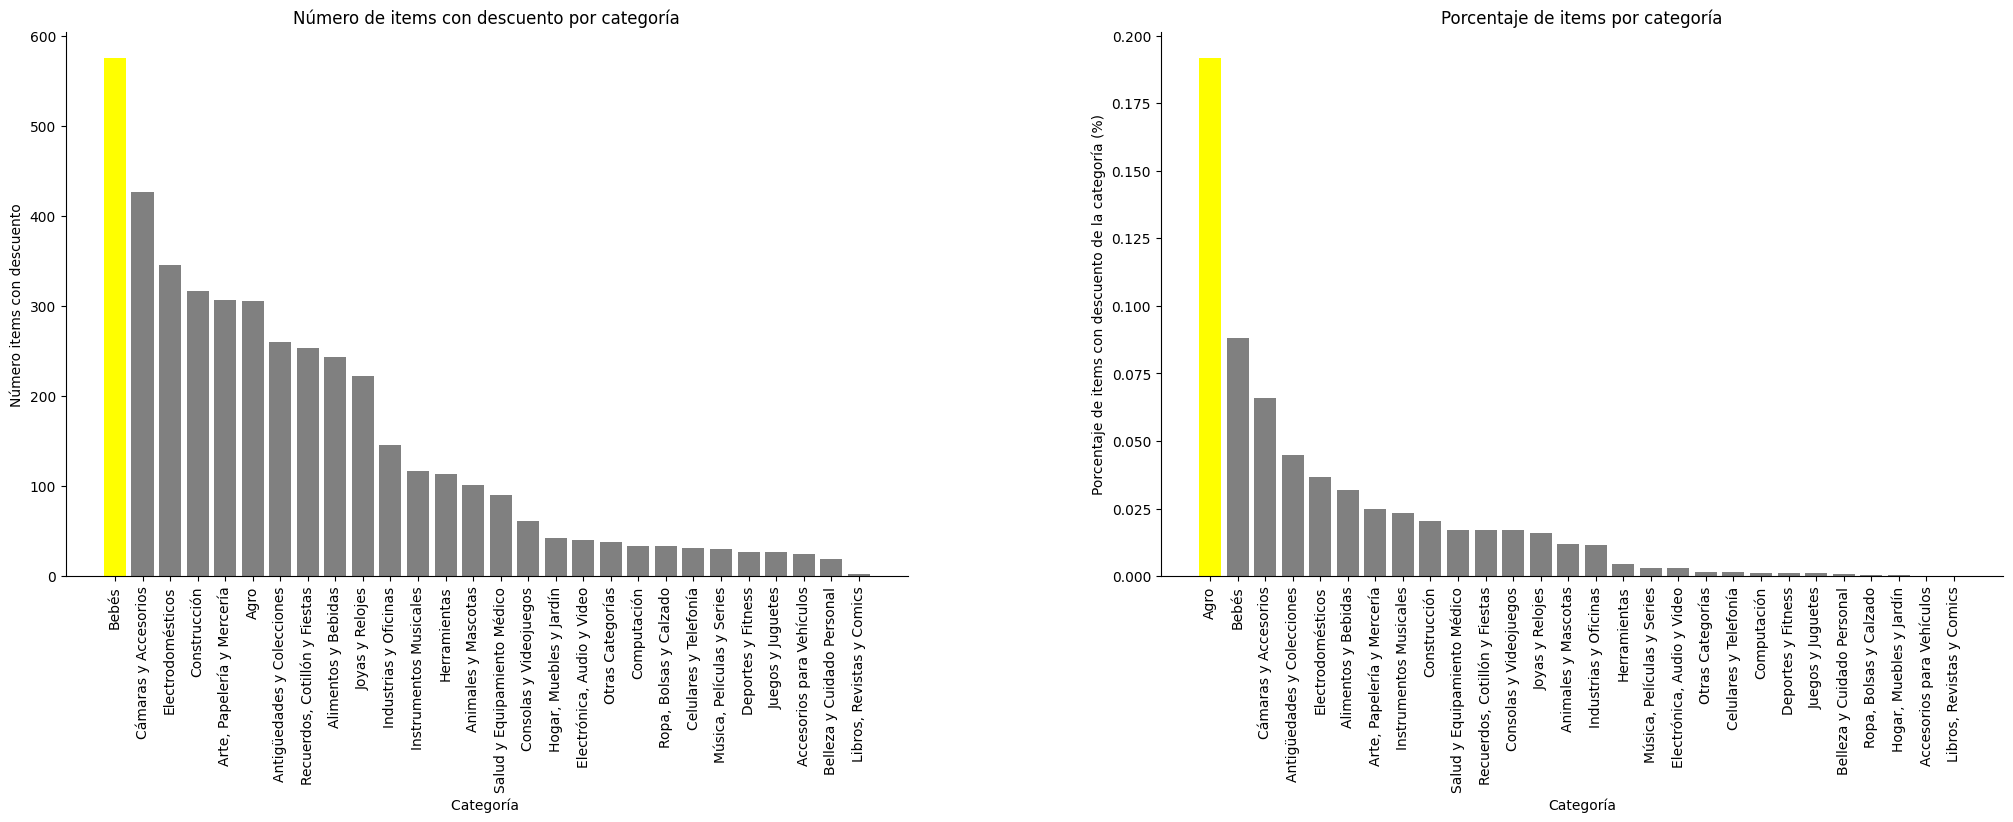

El top 3 de categorías con mayor número de items con descuento fueron: ['Bebés', 'Cámaras y Accesorios', 'Electrodomésticos']
El top 3 de categorías que mayores descuentos tienen con respecto al numero total de items disponibles : ['Agro', 'Bebés', 'Cámaras y Accesorios']


In [24]:
agrupaciones_categorias_items = agrupaciones_categorias_items.sort(by='Número items', descending=True)
categorias_numeroitems = agrupaciones_categorias_items["category_name"].to_list()
numeroitems = agrupaciones_categorias_items['Número items'].to_list()
top_3_categorias=categorias_numeroitems[:3]


agrupaciones_categorias_items = agrupaciones_categorias_items.sort(by='Porcentaje de la categoría (%)', descending=True)
categorias_porcentaje = agrupaciones_categorias_items["category_name"].to_list()
porcentaje_categoria = agrupaciones_categorias_items['Porcentaje de la categoría (%)'].to_list()
top_3_sucateggoria=categorias_porcentaje[:3]


x_vars = [categorias_numeroitems, categorias_porcentaje]
y_vars = [numeroitems, porcentaje_categoria]
x_labels = ["Categoría ", "Categoría"]
y_labels = ["Número items con descuento", "Porcentaje de items con descuento de la categoría (%)"]
titles = ["Número de items con descuento por categoría", "Porcentaje de items por categoría"]
texto= f"El top 3 de categorías con mayor número de items con descuento fueron: {top_3_categorias}"

top_3_desucategoria=f"El top 3 de categorías que mayores descuentos tienen con respecto al numero total de items disponibles : {top_3_sucateggoria}"
print("¿Cuáles son las categorías que más descuentos tienen? Comparación entre ella y sobre el número de items disponibles  ")
customized_bar_plot(2, x_vars, y_vars, x_labels, y_labels, titles)
print(texto)
print(top_3_desucategoria)

podemos observar que a pesar de que la categoría  electrodomésticos es la que mayor items de descuento la categoría agro es la que más items ofrece con respecto a su número total de items

In [25]:
#Descuento promedio y precio por categoría
preciopromedio_porcategoria=items_df.group_by('category_name').agg(
    pl.col('Proporcion_Descuento').mean().alias("Descuento promedio"),
    pl.col('price').mean().alias("Precio promedio")
).sort(by='Descuento promedio',descending=True)
print(preciopromedio_porcategoria)

shape: (28, 3)
┌───────────────────────────────┬────────────────────┬─────────────────┐
│ category_name                 ┆ Descuento promedio ┆ Precio promedio │
│ ---                           ┆ ---                ┆ ---             │
│ str                           ┆ f64                ┆ f64             │
╞═══════════════════════════════╪════════════════════╪═════════════════╡
│ Hogar, Muebles y Jardín       ┆ 0.441274           ┆ 977.165238      │
│ Ropa, Bolsas y Calzado        ┆ 0.392394           ┆ 281.251818      │
│ Herramientas                  ┆ 0.380867           ┆ 734.042281      │
│ Joyas y Relojes               ┆ 0.342433           ┆ 577.798964      │
│ Cámaras y Accesorios          ┆ 0.32992            ┆ 3525.199742     │
│ Celulares y Telefonía         ┆ 0.328967           ┆ 3406.942258     │
│ Computación                   ┆ 0.327529           ┆ 4821.971212     │
│ Consolas y Videojuegos        ┆ 0.325777           ┆ 2510.262459     │
│ Arte, Papelería y Mercería    ┆ 0.

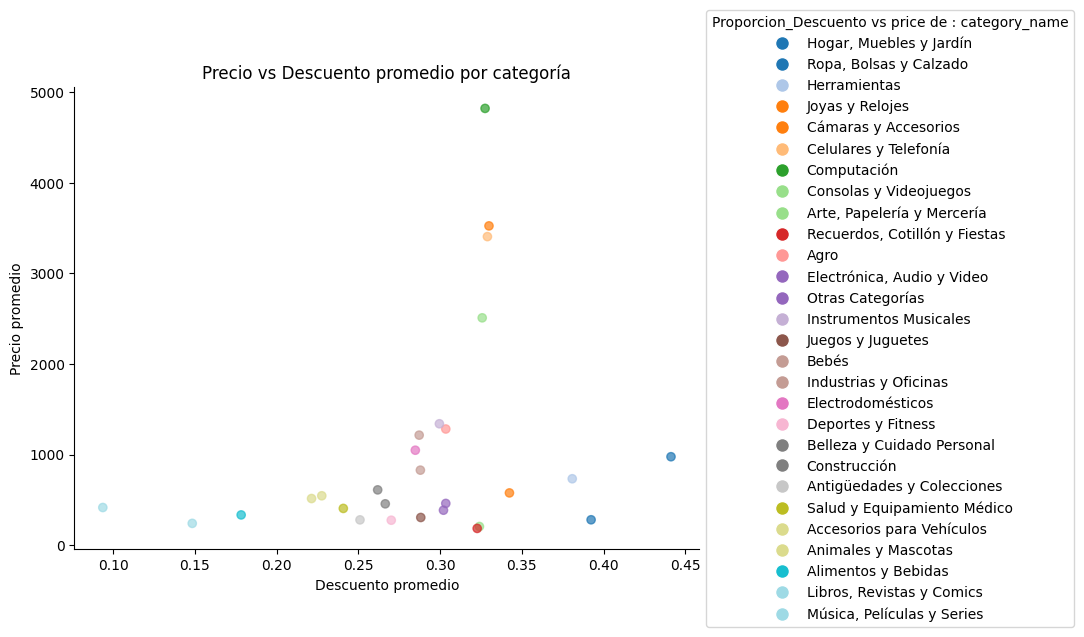

Podemo


In [26]:
plot_precio_vs_descuento(items_df, 'category_name', 'Proporcion_Descuento', 'price')
print("Podemo")

Al observar las categorías que tienen precios promedio más altos, se puede notar lo siguiente las categorías ,Joyería y Relojes y Cámaras y Accesorios aparecen como categorías que tienen precios promedio elevados por encime de $4000. Estas categorías están asociadas con descuentos promedio en el rango de 0.25 a 0.35.Computación también tiene precios promedio relativamente altos erca de $3500 en promedio , con un descuento similar al de las categorías anteriores, en el rango de 0.30. También podemos obervar categorías de precios bajos que fluctuan mucho entre los descuentos promedios, no hay una relación clara entre el descuento y promedio pero si se pueden agrupar algunas categorías de alta gamma.

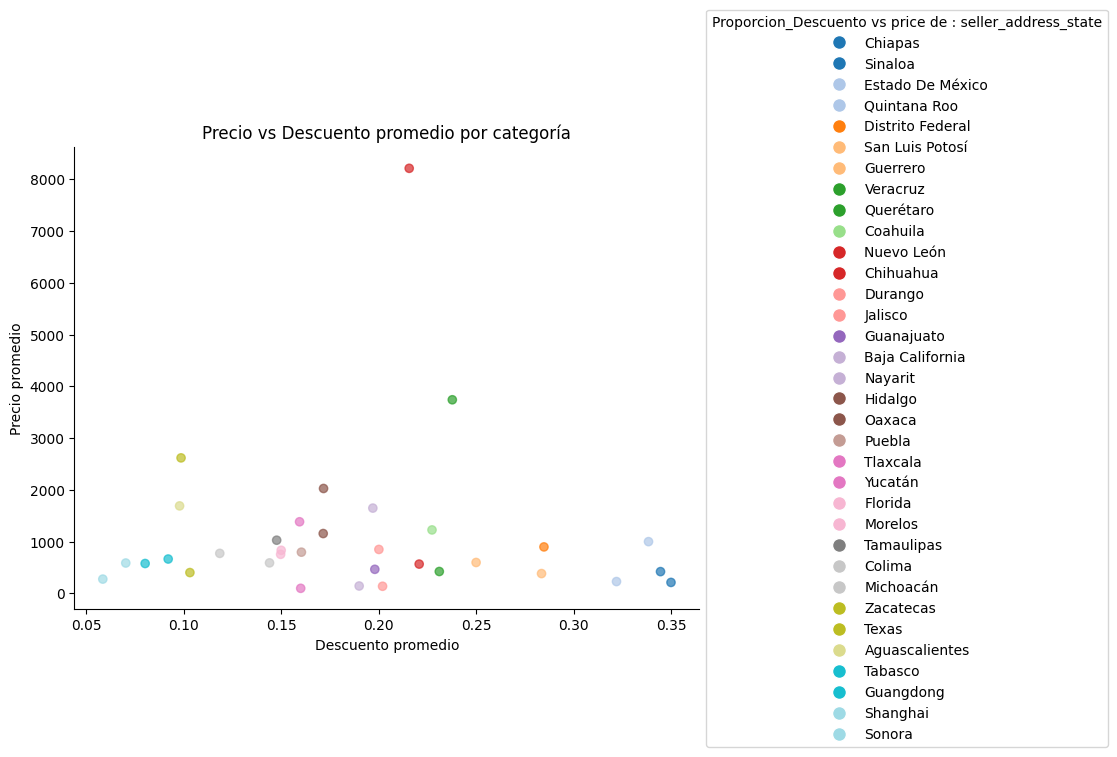

In [27]:
plot_precio_vs_descuento(items_df, 'seller_address_state', 'Proporcion_Descuento', 'price')


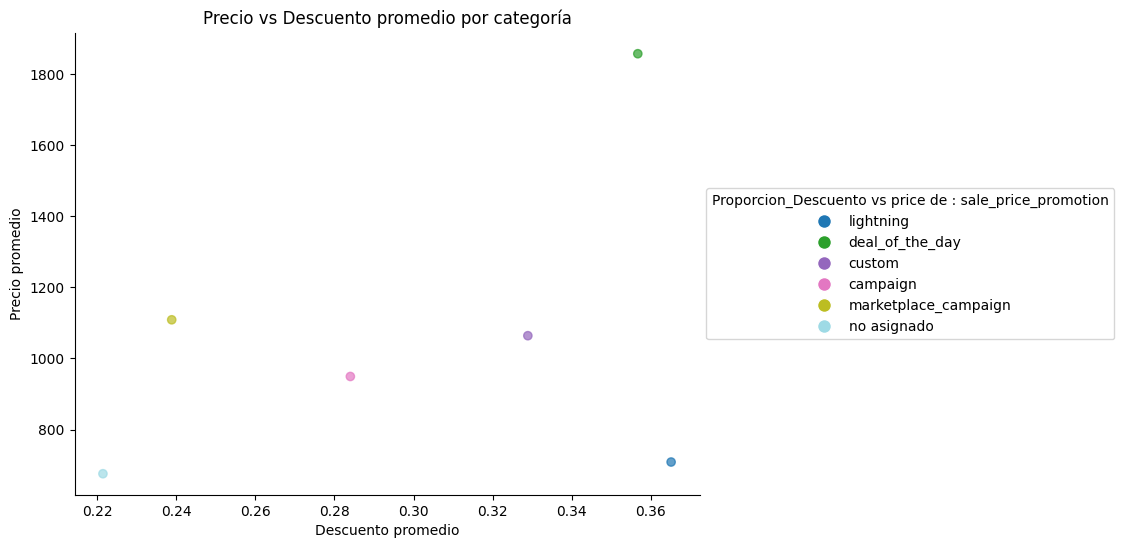

In [28]:
plot_precio_vs_descuento(items_df, 'sale_price_promotion', 'Proporcion_Descuento', 'price')


¿Cuántos items en descuento hay por cada variable categórica?


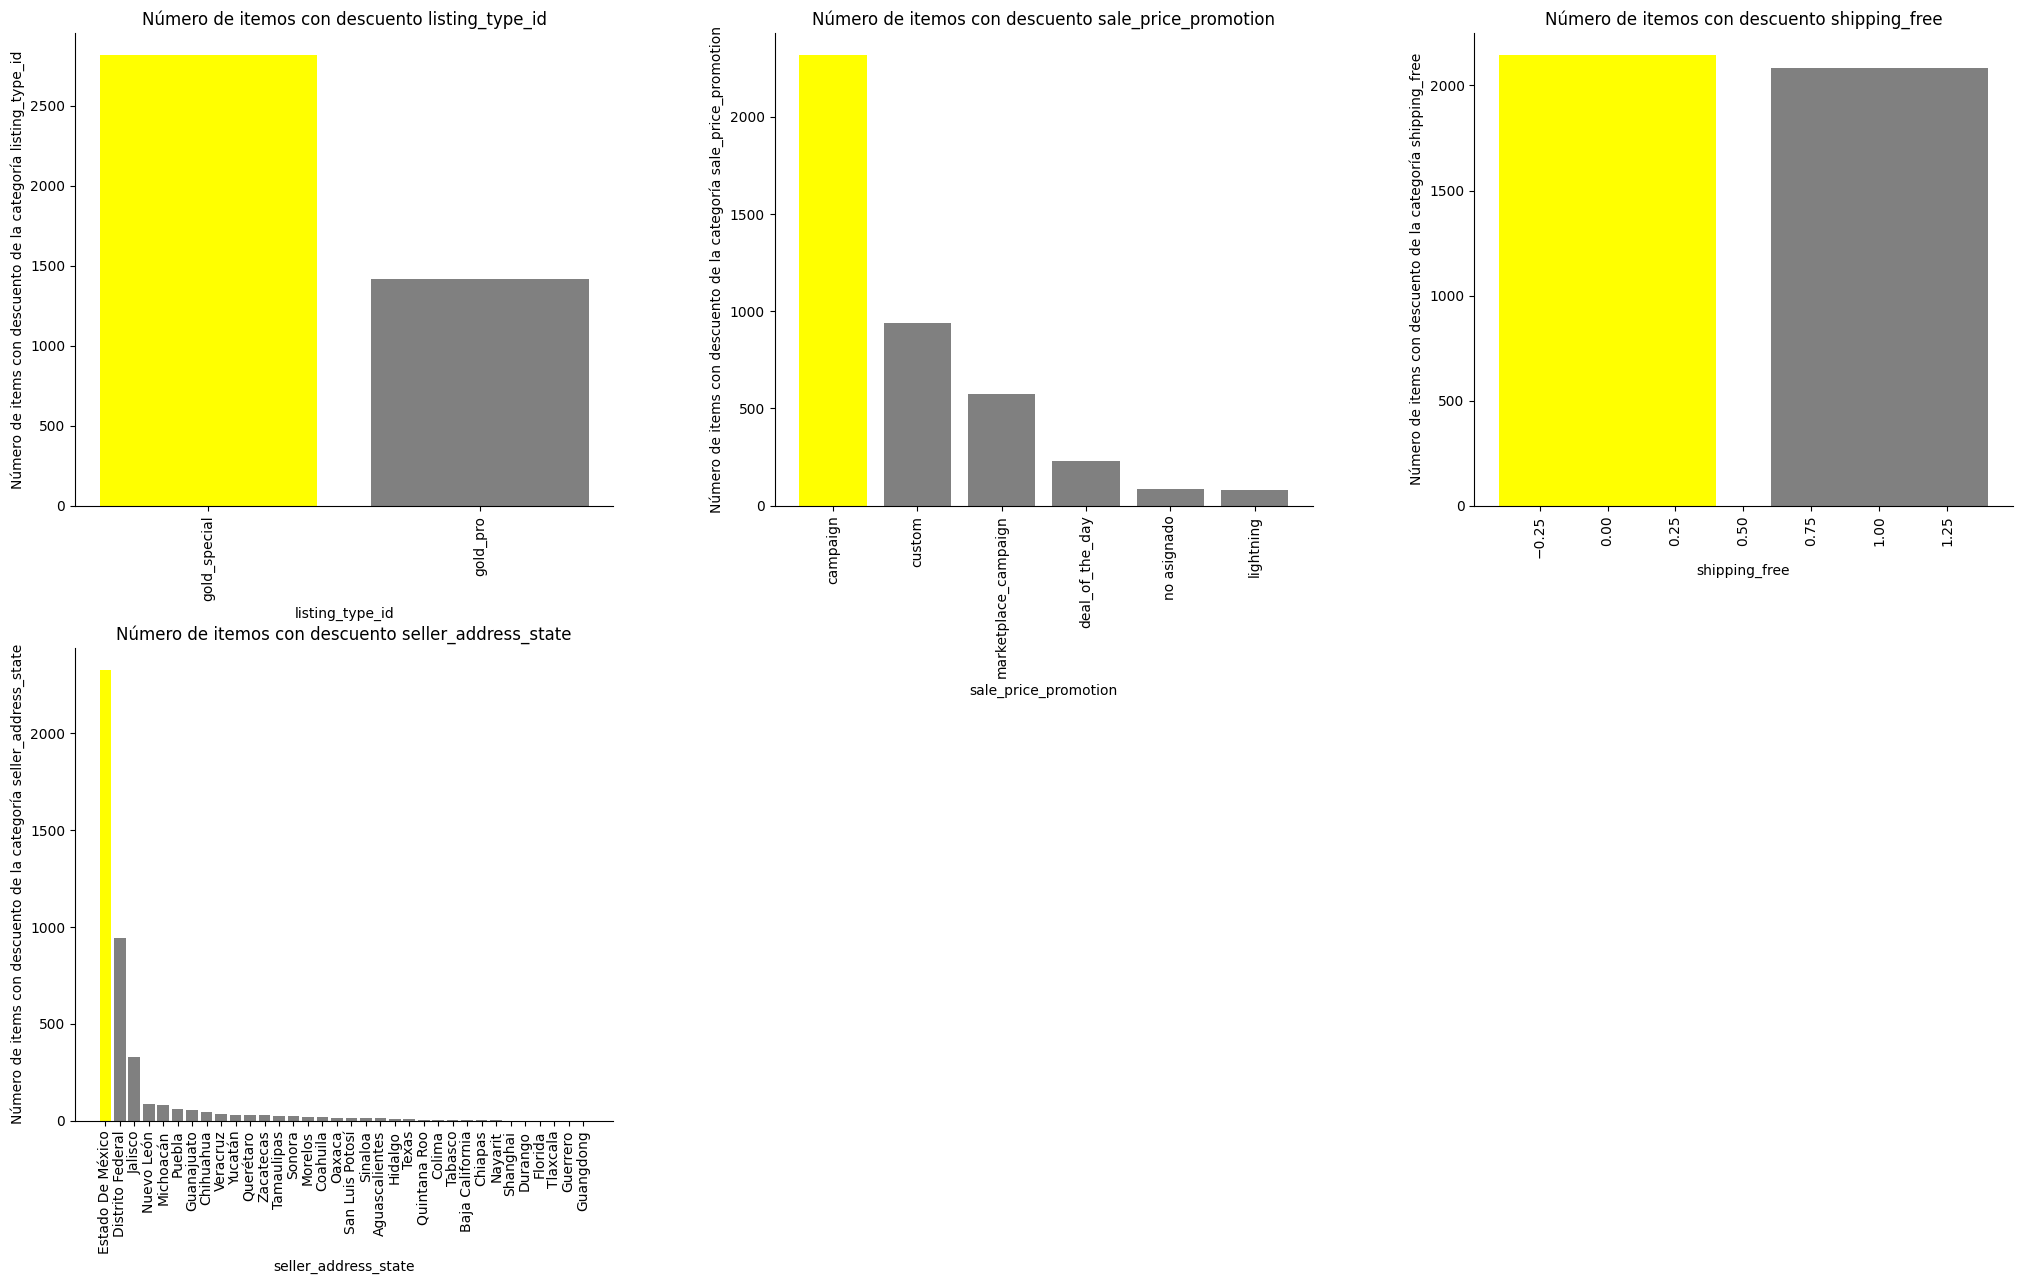

In [29]:
print("¿Cuántos items en descuento hay por cada variable categórica?")
columns_a_plotear = ['listing_type_id', 'sale_price_promotion', 'shipping_free',"seller_address_state"]
x_vars = []
y_vars = []
x_labels = []
titles = []
y_labels = []
for column in columns_a_plotear:
    agrupacion = agrupacion_por_columna(items_df, [column])
    x_vals = agrupacion[column].to_list()
    y_vals = agrupacion['Número items'].to_list()
    x_vars.append(x_vals)
    y_vars.append(y_vals)
    y_labels.append(f"Número de items con descuento de la categoría {column}")
    x_labels.append(column)  
    titles.append(f"Número de itemos con descuento {column}")  

customized_bar_plot(len(columns_a_plotear), x_vars, y_vars, x_labels, y_labels, titles)

In [30]:
print("Fecha oferta mínima", items_df.select('sale_price_start_time').min())
print("Fecha oferta máxima",items_df.select('sale_price_start_time').max())

Fecha oferta mínima shape: (1, 1)
┌───────────────────────┐
│ sale_price_start_time │
│ ---                   │
│ datetime[μs]          │
╞═══════════════════════╡
│ 2024-08-07 23:30:00   │
└───────────────────────┘
Fecha oferta máxima shape: (1, 1)
┌───────────────────────┐
│ sale_price_start_time │
│ ---                   │
│ datetime[μs]          │
╞═══════════════════════╡
│ 2024-09-12 03:13:25   │
└───────────────────────┘


In [31]:
items_df.columns
items_df = items_df.with_columns(
    (pl.col("Duracion_Oferta").cast(pl.Float64) / (24 * 60 * 60 * 10**6)).alias("DuracionOferta_dias"),
    (pl.col("Tiempo_duracion_actual_articulo").cast(pl.Float64) / (24 * 60 * 60 * 10**3)).alias("EdadProducto_dias")
)

In [32]:
col_numericas = items_df.select(pl.col(pl.Int64, pl.Float64)).columns
items_df.select(col_numericas).describe()

statistic,price,available_quantity,original_price,sale_price_amount,installments_quantity,installments_amount,installments_rate,base_price,initial_quantity,Probable_numero_articulos_vendidos,Proporcion_vendida,Probable_ganacia_total,DiferenciaPrecio,Proporcion_Descuento,DuracionOferta_dias,EdadProducto_dias
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",4228.0,4228.0,4228.0,4228.0,4228.0,4228.0,4228.0,4228.0,4228.0,4228.0,4228.0,4228.0,4228.0,4228.0,4140.0,4228.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.0,0.0
"""mean""",1035.287138,238.908467,1481.562576,1035.287138,15.730842,93.951149,26.200047,1368.073647,3329.599574,3090.691107,0.885256,1.6043e6,446.275438,0.292051,26.48957,335.764742
"""std""",3020.124244,1794.720698,4100.283125,3020.124244,10.228866,208.067591,22.214013,3999.060705,11084.48952,10406.444536,0.166436,8.1953e6,1220.48454,0.180658,8.801478,322.540467
"""min""",9.5,1.0,10.0,9.5,0.0,0.0,0.0,9.5,1.0,0.0,0.0,0.0,0.5,0.01358,0.249988,0.055598
"""25%""",154.85,1.0,229.0,154.85,3.0,11.03,0.0,199.0,177.0,141.0,0.857143,48057.3,43.9,0.13,29.952755,117.594778
"""50%""",299.98,50.0,486.0,299.98,24.0,33.11,45.03,325.0,628.0,537.0,0.953789,193290.0,124.75,0.27,30.0,256.404164
"""75%""",821.64,200.0,1239.0,821.64,24.0,99.9,45.03,1124.0,2271.0,2045.0,0.991453,889148.48,367.0,0.43,30.0,432.364604
"""max""",55869.72,50000.0,73999.0,55869.72,24.0,3724.65,45.03,73999.0,218837.0,218337.0,0.999993,3.70293e8,21215.59,0.794118,54.270139,3051.132752


In [33]:
items_df.select('price').describe()

statistic,price
str,f64
"""count""",4228.0
"""null_count""",0.0
"""mean""",1035.287138
"""std""",3020.124244
"""min""",9.5
"""25%""",154.85
"""50%""",299.98
"""75%""",821.64
"""max""",55869.72


¿Hay correlación entre las variables numéricas?


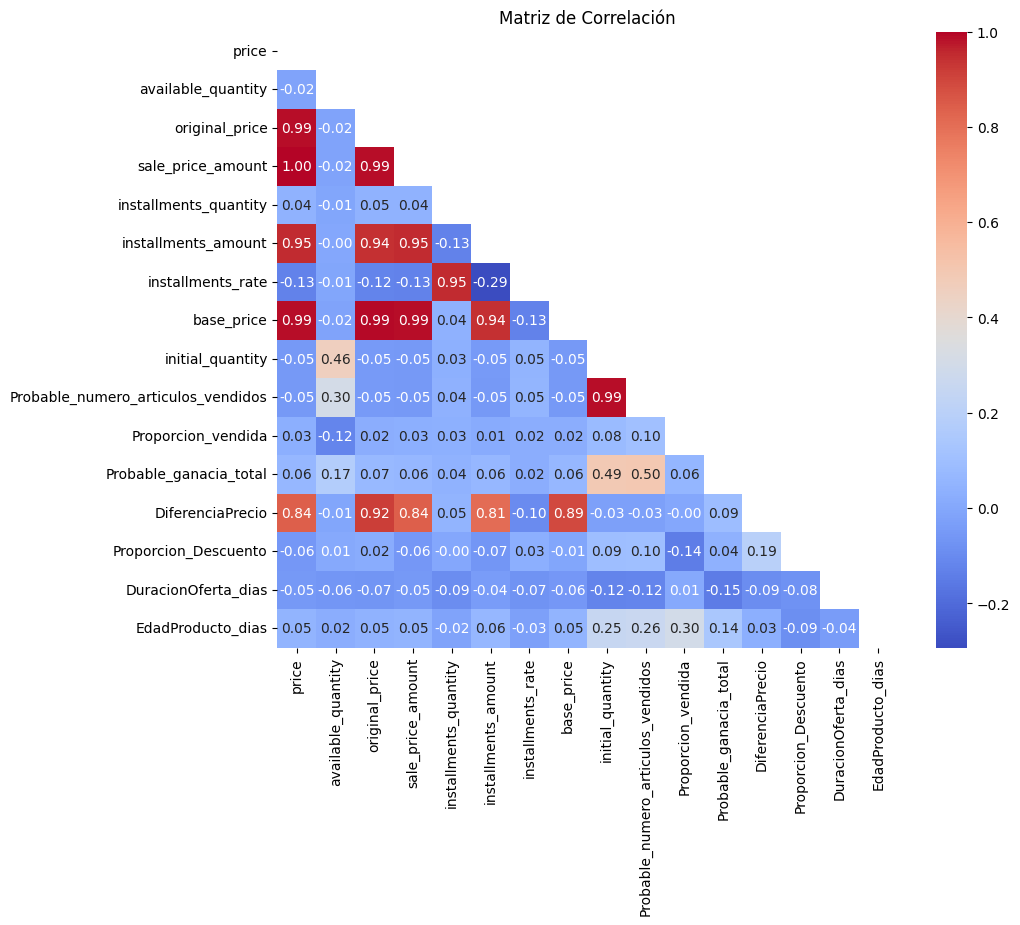

In [34]:
print("¿Hay correlación entre las variables numéricas?")
correlation_matrix = items_df.drop_nulls().select(col_numericas).corr()
correlation_matrix_np = correlation_matrix.to_numpy()
mask = np.triu(np.ones_like(correlation_matrix_np, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_np, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", 
            xticklabels=col_numericas, yticklabels=col_numericas)
plt.title('Matriz de Correlación')
plt.show()


¿Hay relación entre el precio y otras variables numéricas?


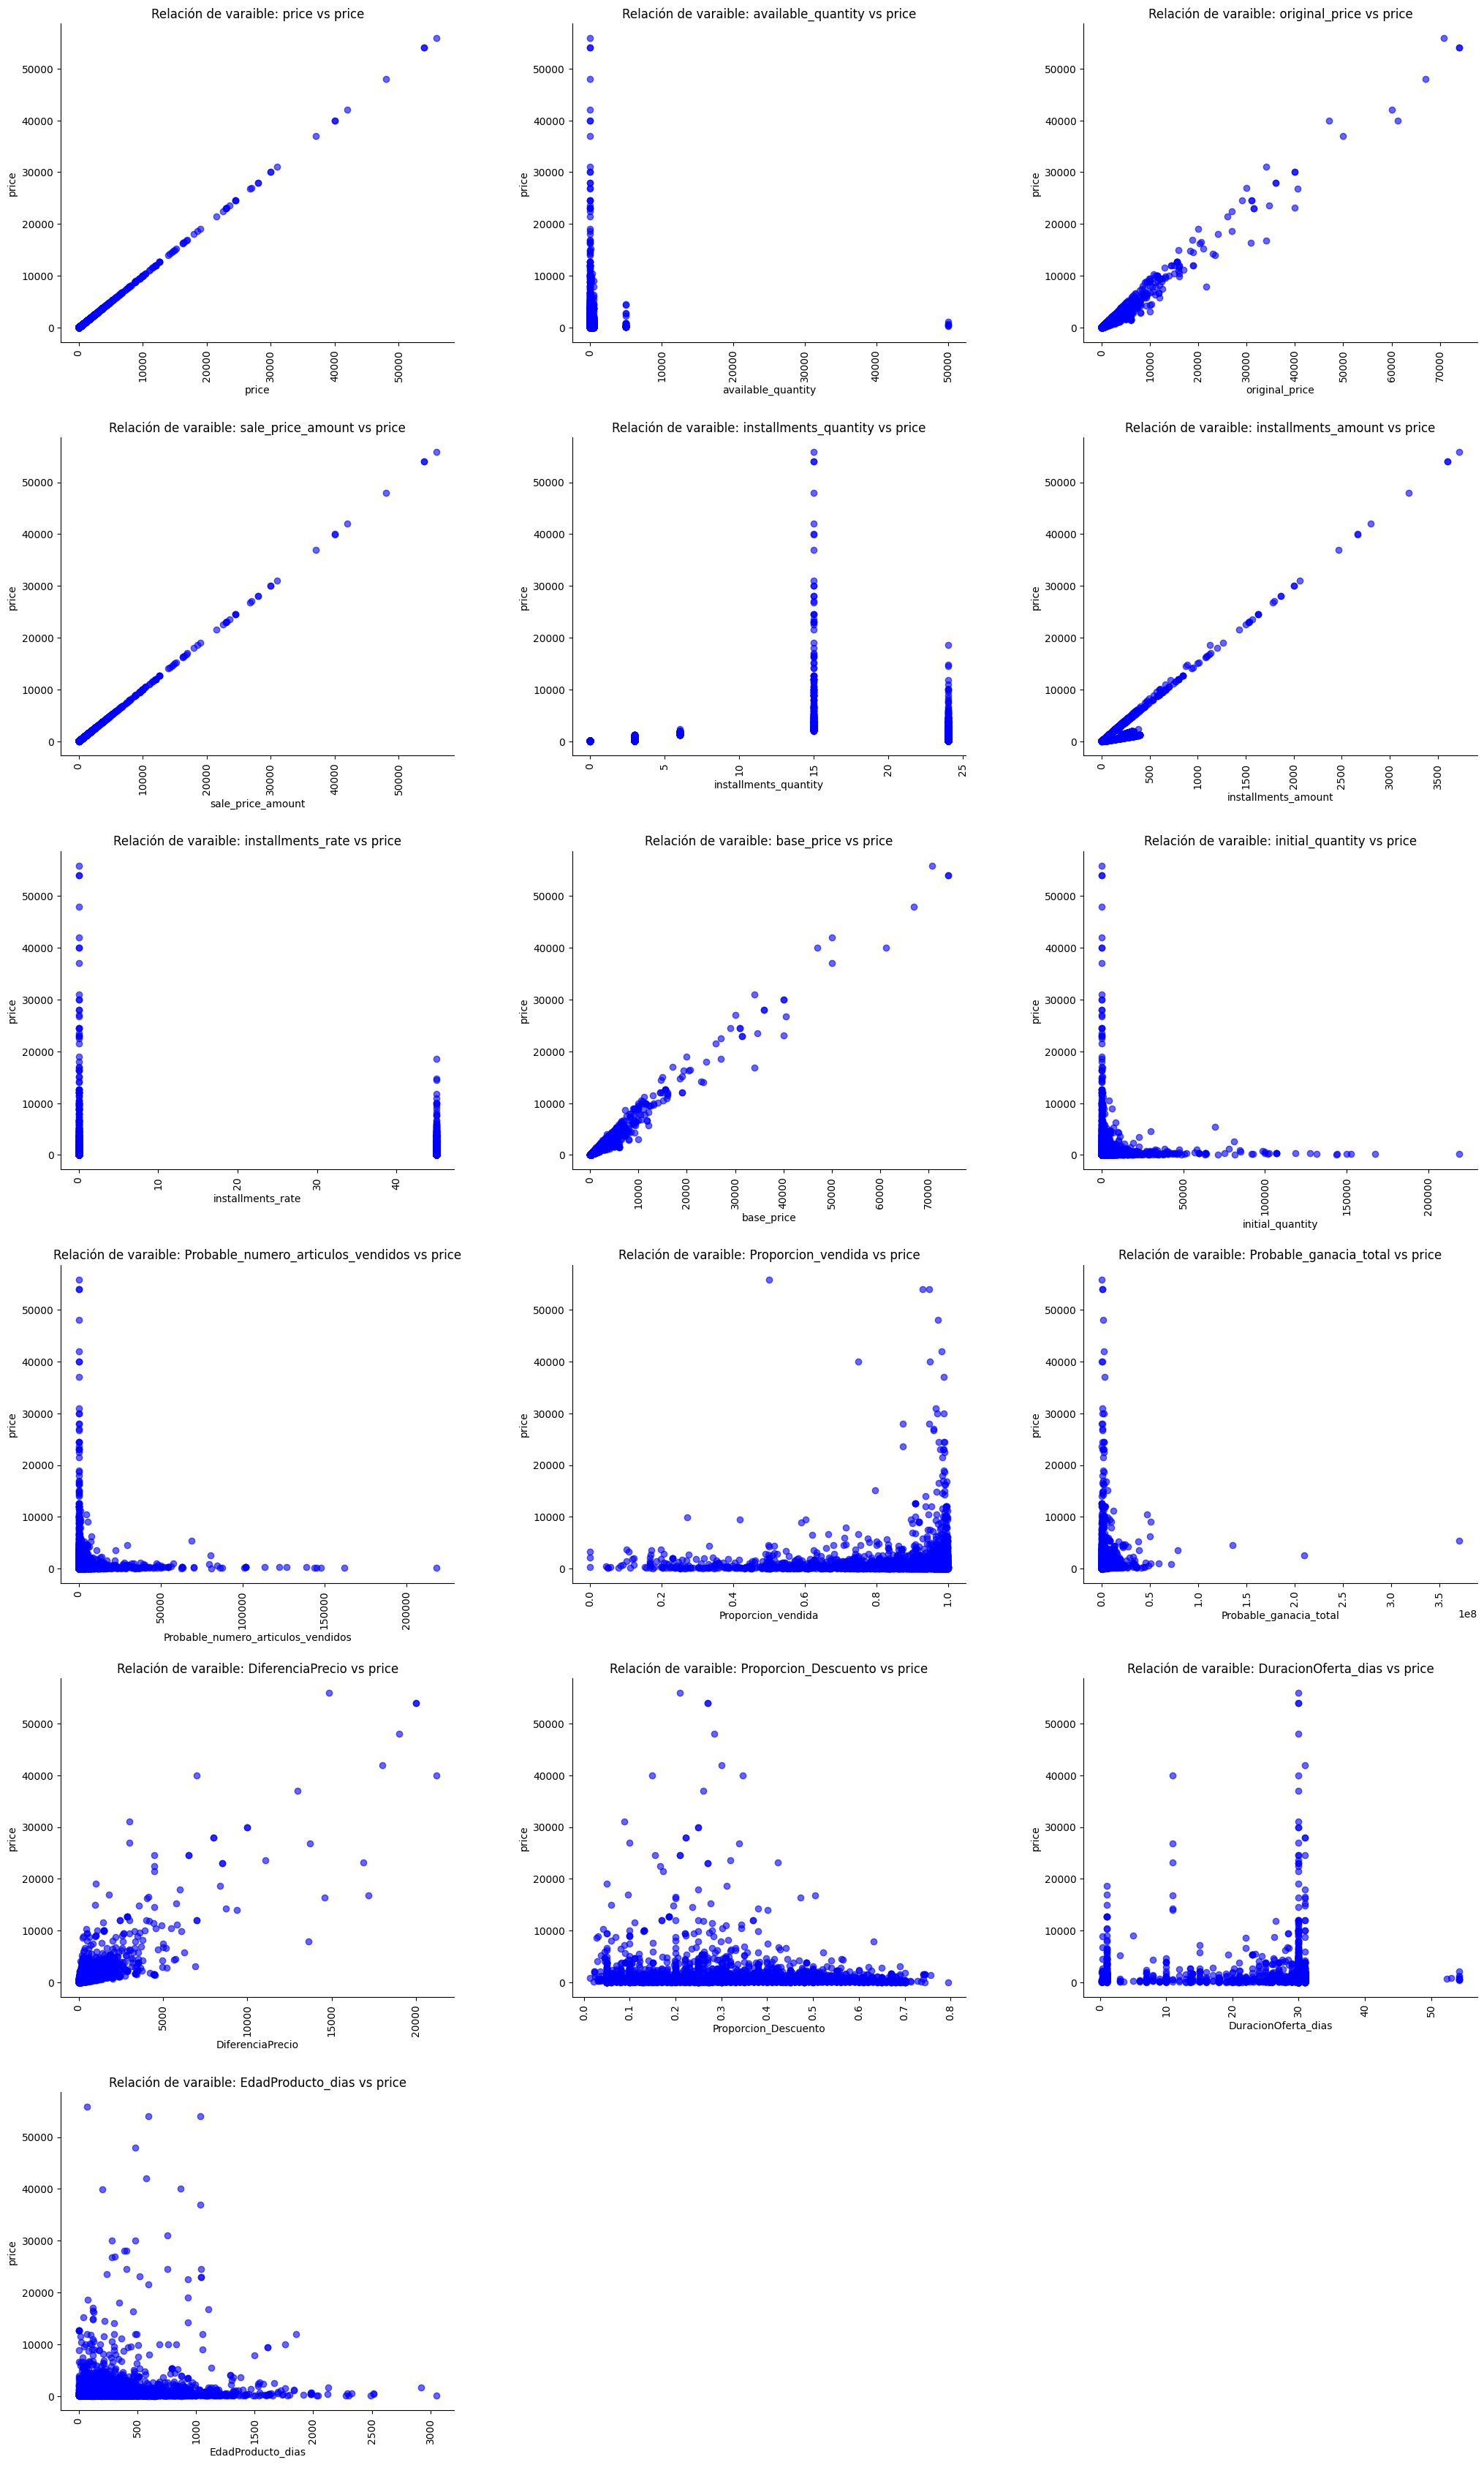

In [35]:
print("¿Hay relación entre el precio y otras variables numéricas?")
price_data = items_df['price'].to_numpy()
x_vars = [items_df[col].to_numpy() for col in col_numericas]  
y_vars = [price_data] * len(col_numericas)

x_labels = col_numericas  
y_labels = ['price'] * len(col_numericas)  
titles = [f'Relación de varaible: {x} vs price' for x in col_numericas]

customized_scatter_plot_with_line(
    num_subplots=len(col_numericas),
    x_vars=x_vars,
    y_vars=y_vars,
    x_labels=x_labels,
    y_labels=y_labels,
    titles=titles
)

¿Hay relación entre variables categóricas y el precio?


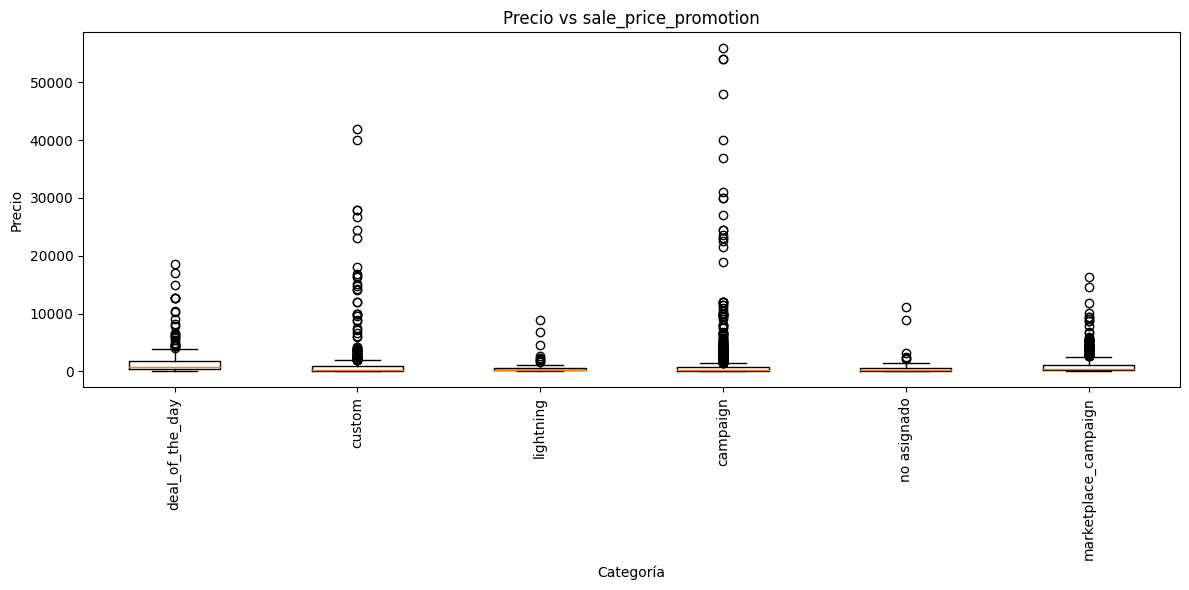

In [36]:
print("¿Hay relación entre variables categóricas y el precio?")
plot_precio_vs_categoria_polars(items_df, 'sale_price_promotion', 'price')


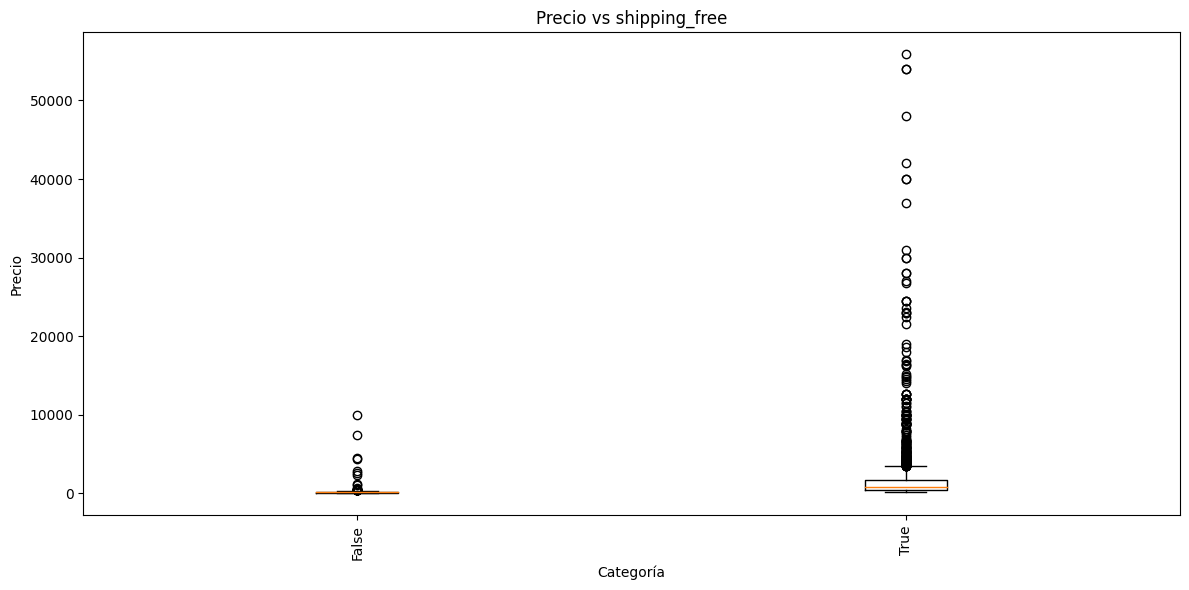

In [37]:
plot_precio_vs_categoria_polars(items_df, 'shipping_free', 'price')


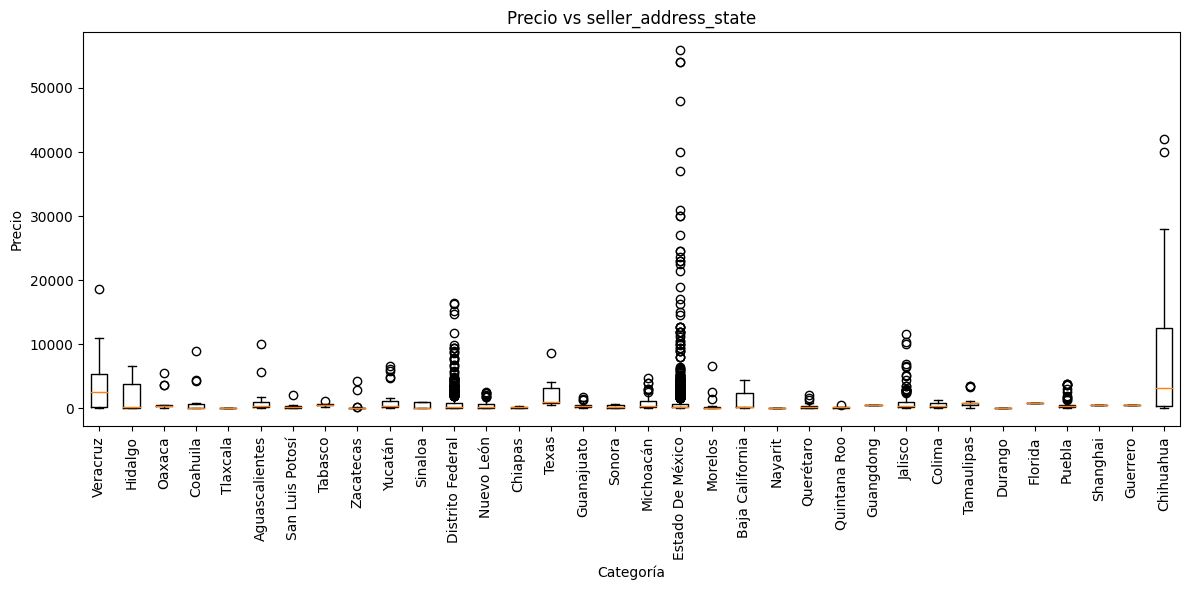

In [38]:
plot_precio_vs_categoria_polars(items_df, 'seller_address_state', 'price')

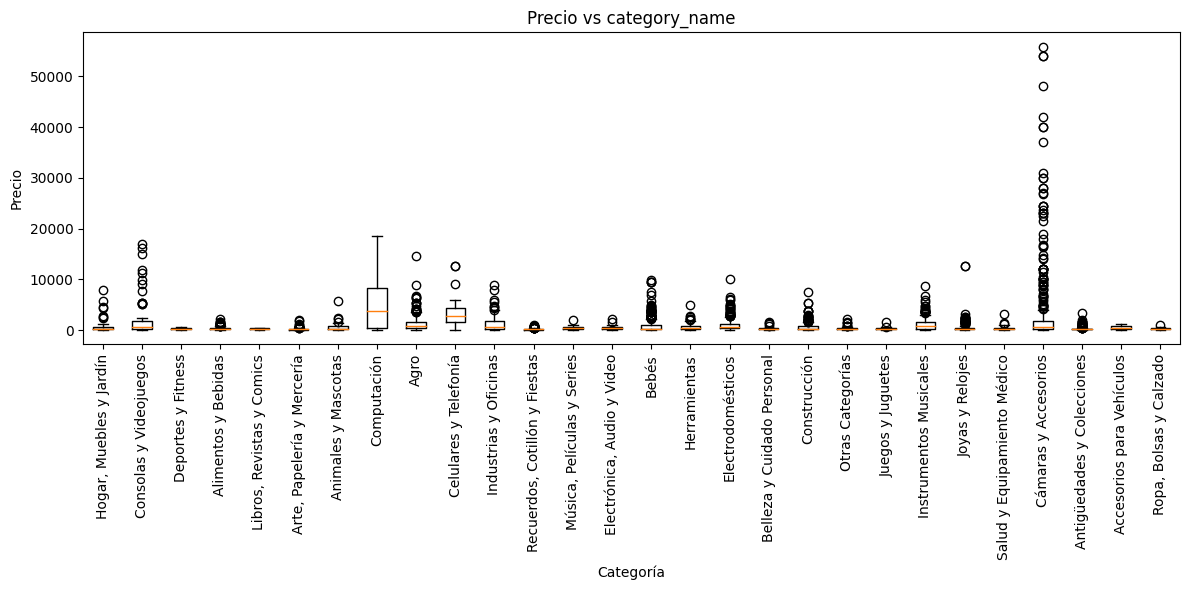

In [39]:
plot_precio_vs_categoria_polars(items_df, 'category_name', 'price')


#### Distribución de la variable precio

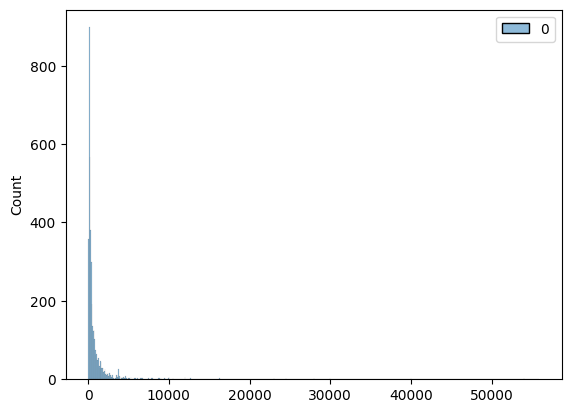

In [40]:
sns.histplot(items_df.select('price'))
plt.show()

In [41]:
items_df.select('price').quantile(.90)

price
f64
1999.0


In [42]:
import polars as pl

items_df = items_df.with_columns(pl.lit(0).alias('outlier'))

quantile_90 = items_df['price'].quantile(0.90)
filtro_out = items_df['price'] > quantile_90

items_df = items_df.with_columns(
    pl.when(filtro_out).then(1).otherwise(items_df['outlier']).alias('outlier')
)

In [43]:
items_df.filter(items_df['outlier']==1)['price'].min()

2005.19

In [44]:
items_df.group_by('outlier').agg(
    pl.count('id').alias("Número de items")
)

outlier,Número de items
i32,u32
0,3805
1,423


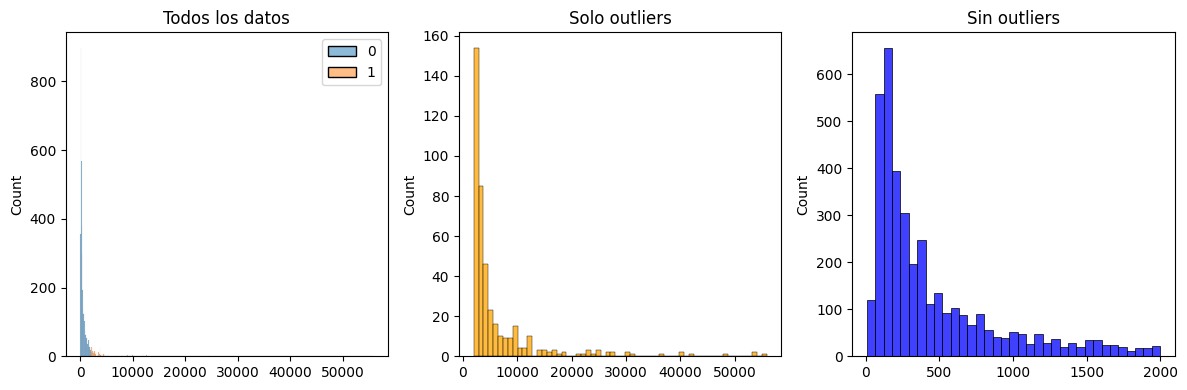

In [45]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

sns.histplot(x=items_df['price'].to_numpy(), hue=items_df['outlier'].to_numpy(), ax=ax[0])
ax[0].set_title('Todos los datos')

sns.histplot(x=items_df.filter(items_df['outlier']==1)['price'].to_numpy(), ax=ax[1], color='orange')
ax[1].set_title('Solo outliers')

sns.histplot(x=items_df.filter(items_df['outlier']==0)['price'].to_numpy(), ax=ax[2], color='blue')
ax[2].set_title('Sin outliers')

plt.tight_layout()
plt.show()


In [46]:
items_df_final=items_df.drop_nulls()
items_df_final=items_df_final.select('id',
 'category_name',
 'listing_type_id',
 'price',
 'sale_price_promotion',
 'shipping_free',
 'installments_quantity',
 'installments_rate',
 'seller_address_state',
 'initial_quantity',
 'DuracionOferta_dias',
 'EdadProducto_dias',
 'Proporcion_vendida')

In [47]:
items_df_final.write_csv('training_database.csv')